# Code Explanation and Examples

## Introduction

In this notebook, we will discuss and illustrate the implementation of using the CausalBO package. We will provide explanations along with code samples to help you understand the key concepts and steps involved in the code.

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Code Explanation](#code-explanation)
    1. [Standard CBO Loop](#standard-cbo)
        1. [Importing Libraries](#s-importing-libraries)
        2. [Loading Data](#s-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#s-cbo-alg)
    2. [Custom CBO Loop](#custom-alg)
        1. [Importing Libraries](#c-importing-libraries)
        2. [Loading Data](#c-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#c-cbo-alg)

## Prerequisites <a name="prerequisites"></a>

Before running the code samples, ensure you have the necessary libraries installed. Installing CausalBO through pip will ensure these dependencies are installed. Otherwise, you can run the following code to install them:

In [4]:
import sys
!{sys.executable} -m pip install "numpy>=1.23.5" "pandas>=1.5.3" "torch>=2.0.0" "scipy>=1.8.1" "botorch>=0.8.3" "gpytorch>=1.9.1" "dowhy>=0.9.1" "networkx>=2.8.8"


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Code Explanation <a name="code-explanation"></a>

### Standard CBO Loop <a name="standard-cbo"></a>

#### Step 1: Importing Libraries <a name="s-importing-libraries"></a>

Begin by importing all of the necessary libraries for running a simple causal Bayesian optimization task using the included algorithm.

In [1]:
from causalbo.cbo_loop import CBOLoop
from causalbo.sample_data.toy_graph import ToyGraph

c:\Users\capta\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step 2: Loading Data <a name="s-loading-data"></a>

For the simplest example, some sample DAGs and associated datasets have been provided. We can load all of the data we need by instantiating one of these objects. The object contains information about the graph structure, ground truth functions, and a randomly generated set of noisy observational data.

{'X': [-5, 5], 'Z': [-5, 20]}
          X         Z         Y
0 -0.704873  0.799393 -0.986043
1  0.738039 -0.227229 -0.612177
2 -0.736996  0.087984  1.205263
3  1.295972  0.930769 -1.254709
4  0.769988 -0.130837  0.416113
5 -2.003066  5.535750 -0.119479
6 -0.629566  1.776501 -1.666294
7 -1.168048  4.147660 -1.244483
8 -0.105347  0.844130 -0.159706
9  0.134559  1.607938 -1.460476


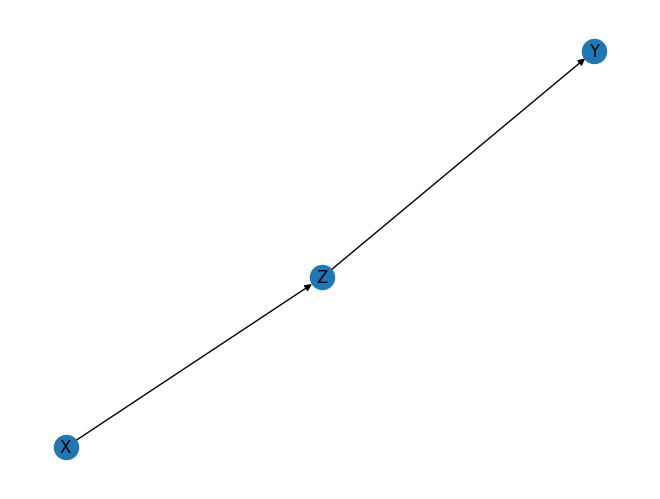

In [2]:
toy_graph = ToyGraph()

# Display sample data
toy_graph.draw()
print(toy_graph.interventional_domain)
print(toy_graph.observational_samples.head(10))

#### Step 3: Causal Bayesian Optimization Algorithm <a name="s-cbo-alg"></a>

Now, we can run the included CBO algorithm, originally developed by V. Aglietti et. al. and adapted for use in this package.

In [ ]:
(global_optimum, global_optimal_set, gp, D_i, D_o) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='max',
        objective_function=toy_graph.obj_func,
        early_stopping_iters=2, verbose=False)

print(global_optimum, global_optimal_set, gp)

### Custom CBO Loop <a name="custom-alg"></a>

It is also possible to use the provided modules to write a custom loop using BoTorch.

#### Importing Libraries <a name="c-importing-libraries"></a>

These imports will give access to the lower-level modules used in the simple example above to allow for the creation of a custom loop using BoTorch, as well as generating custom data.

In [2]:
from causalbo.modules import CausalMean, CausalRBF
from causalbo.do_calculus import SCM
from causalbo.causal_helper_funcs import *

from pandas import DataFrame

import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

c:\Users\capta\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loading Data <a name="c-loading-data"></a>

For this example, we will generate some custom data using the same DAG structure and ground truth functions provided in the ToyGraph import.

In [10]:
# Ground truth functions
def X(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return input_tensor + noise

def Z(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return (torch.exp(-input_tensor)) + noise

def Y(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return ((torch.cos(input_tensor)) - (torch.exp(-input_tensor / 20))) + noise

# Interventional domain = boundaries for each variable.
interventional_domain = {'X': [-5,5], 'Z': [-5,20]}

# Graph = DAG corresponding to causal connections.
graph = SCM([('X', 'Z'), ('Z', 'Y')])

# Store objective functions in a dict for easy access later.
objective_functions = { 'X': lambda x: Y(Z(X(x))),
                        'Z': lambda z: Y(Z(z)),
                        'Y': lambda y: Y(y)}

# Generate some noisy observational data.
obs_data_x = X(torch.randn(1000, 1).view(-1,1), noise_stdev=1)
obs_data_z = Z(obs_data_x, noise_stdev=1)
obs_data_y = Y(obs_data_z, noise_stdev=1)

# Add observations to DataFrame for easy access later.
observational_samples = DataFrame()
observational_samples['X'] = torch.flatten(obs_data_x).tolist()
observational_samples['Z'] = torch.flatten(obs_data_z).tolist()
observational_samples['Y'] = torch.flatten(obs_data_y).tolist()

# Fit observations to DAG to estimate causal effects.
graph.fit(observational_samples)

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


#### Causal Bayesian Optimization Algorithm <a name="c-cbo-alg"></a>

With our data generated, we can now write a standard BoTorch optimization loop, and plug in the CausalRBF kernel and CausalMean mean functions, keeping everything else nearly identical to the non-causal implementation.

In [14]:
# Ignore warnings regarding data scaling for simple example
import warnings
warnings.filterwarnings("ignore")

train_x = torch.rand(5, 1)  # Random initial points
train_y = objective_functions['X'](train_x)

# Initialize the GP model
gp = SingleTaskGP(train_x, train_y,
                  covar_module=CausalRBF(
                      interventional_variable=['X'],
                      causal_model=graph
                  ),
                  mean_module=CausalMean(
                      interventional_variable=['X'],
                      causal_model=graph
                  ))

mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Initialize the acquisition function (Expected Improvement)
acq_fn = ExpectedImprovement(gp, best_f=0)

# Bayesian optimization loop
num_iterations = 10
for iteration in range(num_iterations):
    # Optimize the acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_fn,
        bounds=torch.tensor(list(subdict_with_keys(interventional_domain, ['X']).values()), dtype=torch.float64).t(),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = objective_functions['X'](new_x)

    # Update the training data
    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, new_y])

    # Update the GP model and fit the hyperparameters
    gp = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    # Update the acquisition function with new observations
    best_f = torch.max(train_y)
    acq_fn = ExpectedImprovement(gp, best_f)

# Retrieve the best-performing point
best_point = train_x[torch.argmin(train_y)]

print("Optimal Solution:", best_point.item())

Optimal Solution: -1.233835396330789
